# Variability analysis

Analyse the effect of parameter changes and double parameter changes on the output of given simulation.
All parameters are changed and the effects on the simulation results/stability is analysed.

In [3]:
from __future__ import print_function
# import and setup database
import django
django.setup()
# import the database API functions and tools
import simapp.db.api as db_api
import multiscale.odesim.db.tools as db_tools

In [4]:
# create model in database
from multiscale.examples.testdata import demo_sbml
print(demo_sbml)
comp_model = db_api.create_model(filepath=demo_sbml)

/home/mkoenig/git/multiscale-galactose/python/multiscalepy/multiscale/examples/models/demo/Koenig_demo_v09.xml


In [5]:
comp_model

<CompModel: <SBML: Koenig_demo_v09>>

In [6]:
import roadrunner
roadrunner.getVersionStr()

'1.4.2; Compiler: gcc 4.8.4, C++ version: 199711; JIT Compiler: LLVM-3.4; Date: Jan 13 2016, 11:19:15'

['time', '[e__A]', '[e__C]', '[e__B]', '[c__C]', '[c__B]', '[c__A]']
--------------------------------------------------------------------------------
<roadrunner.RoadRunner() { 
'this' : 0x2a4fe20
'modelLoaded' : true
'modelName' : Koenig_demo_v09
'libSBMLVersion' : LibSBML Version: 5.11.0
'jacobianStepSize' : 1e-05
'conservedMoietyAnalysis' : false
'simulateOptions' : 
< roadrunner.SimulateOptions() 
{ 
'this' : 0x2827f20, 
'reset' : 0,
'structuredResult' : 0,
'copyResult' : 1,
'steps' : 50,
'start' : 0,
'duration' : 5
}>, 
'integrator' : 
< roadrunner.Integrator() >
  settings:
      relative_tolerance: 0.00000001
      absolute_tolerance: 0.00000000000001
                   stiff: true
       maximum_bdf_order: 5
     maximum_adams_order: 12
       maximum_num_steps: 20000
       maximum_time_step: 0
       minimum_time_step: 0
       initial_time_step: 0
          multiple_steps: false
      variable_step_size: true

}>
--------------------------------------------------------------

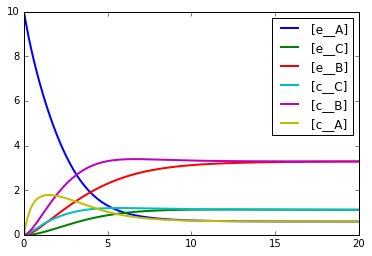

In [12]:
%matplotlib inline

import multiscale.odesim.simulate.roadrunner_tools as rt


# Uset the filepath from the database
r = roadrunner.RoadRunner(comp_model.filepath)
r.selections = ['time'] + ['[{}]'.format(s) for s in r.model.getFloatingSpeciesIds()]
print(r.selections)
rt.set_integrator_settings(r)
s = r.simulate(0, 20)  # timecourse for 20 [s]
r.plot()

## Parameter variability analysis

Vary all single parameters in the model between [0.95-1.05] the original value.

In [16]:
# These are the parameters to vary
parameter_ids = r.model.getGlobalParameterIds()
sorted(parameter_ids)

['Keq_v1',
 'Keq_v4',
 'Km_A',
 'Km_B',
 'Km_C',
 'Vmax_bA',
 'Vmax_bB',
 'Vmax_bC',
 'Vmax_v1',
 'Vmax_v2',
 'Vmax_v3',
 'Vmax_v4',
 'scale_f']

In [28]:
# get values for all parameters
values = {pid: r[pid] for pid in parameter_ids}
# print(values)

# get units from SBML file
import libsbml
doc = libsbml.readSBML(demo_sbml)
sbml_model = doc.getModel()
units = {}
for pid in parameter_ids: 
    p = sbml_model.getParameter(pid)
    unit = p.getUnits()
    units[pid] = (r[pid], unit)
for k,v in units.iteritems():
    print(k, '=', v)

Vmax_v4 = (0.5, 'mole_per_s')
scale_f = (1e-06, 'dimensionless')
Vmax_bB = (2.0, 'mole_per_s')
Vmax_bC = (2.0, 'mole_per_s')
Vmax_bA = (5.0, 'mole_per_s')
Vmax_v2 = (0.5, 'mole_per_s')
Vmax_v3 = (0.5, 'mole_per_s')
Vmax_v1 = (1.0, 'mole_per_s')
Km_A = (1.0, 'mM')
Km_C = (3.0, 'mM')
Km_B = (0.5, 'mM')
Keq_v4 = (2.0, 'dimensionless')
Keq_v1 = (10.0, 'dimensionless')


In [30]:
# now we can setup the single variations
from multiscale.odesim.dist.samples import Sample, SampleParameter
factors = [0.90, 1.10]
samples = []
for pid in parameter_ids:
    for f in factors:
        # create an empty sample
        s = Sample()
        # Set the parameters to the values
        sp = SampleParameter(pid, f * r[pid], unit=units[pid], \
                             parameter_type=db_api.ParameterType.GLOBAL_PARAMETER)
        s.add_parameter(sp)
        samples.append(s)

samples

[{'Km_C': <Km_C = 2.700E+00 [(3.0, 'mM')] (GLOBAL_PARAMETER)>},
 {'Km_C': <Km_C = 3.300E+00 [(3.0, 'mM')] (GLOBAL_PARAMETER)>},
 {'scale_f': <scale_f = 9.000E-07 [(1e-06, 'dimensionless')] (GLOBAL_PARAMETER)>},
 {'scale_f': <scale_f = 1.100E-06 [(1e-06, 'dimensionless')] (GLOBAL_PARAMETER)>},
 {'Vmax_bB': <Vmax_bB = 1.800E+00 [(2.0, 'mole_per_s')] (GLOBAL_PARAMETER)>},
 {'Vmax_bB': <Vmax_bB = 2.200E+00 [(2.0, 'mole_per_s')] (GLOBAL_PARAMETER)>},
 {'Vmax_bC': <Vmax_bC = 1.800E+00 [(2.0, 'mole_per_s')] (GLOBAL_PARAMETER)>},
 {'Vmax_bC': <Vmax_bC = 2.200E+00 [(2.0, 'mole_per_s')] (GLOBAL_PARAMETER)>},
 {'Vmax_bA': <Vmax_bA = 4.500E+00 [(5.0, 'mole_per_s')] (GLOBAL_PARAMETER)>},
 {'Vmax_bA': <Vmax_bA = 5.500E+00 [(5.0, 'mole_per_s')] (GLOBAL_PARAMETER)>},
 {'Vmax_v2': <Vmax_v2 = 4.500E-01 [(0.5, 'mole_per_s')] (GLOBAL_PARAMETER)>},
 {'Vmax_v2': <Vmax_v2 = 5.500E-01 [(0.5, 'mole_per_s')] (GLOBAL_PARAMETER)>},
 {'Vmax_v3': <Vmax_v3 = 4.500E-01 [(0.5, 'mole_per_s')] (GLOBAL_PARAMETER)>},
 {'V

In [34]:
# We want step based integration in the interval [0.0, 20.0]
# TODO: synchronize the possible settings
settings_dict = {db_api.SettingKey.VAR_STEPS: False,\
                 db_api.SettingKey.T_START: 0.0,\
                 db_api.SettingKey.T_END: 20.0, \
                 db_api.SettingKey.STEPS: 100}

# For the tolerances, ... we use the default settings
settings = db_api.create_settings(settings_dict)
for setting in settings:
    print(setting)

INTEGRATOR = ROADRUNNER
VAR_STEPS = False
ABS_TOL = 1e-06
REL_TOL = 1e-06
T_START = 0.0
T_END = 20.0
STEPS = 100
STIFF = True


In [35]:
method = db_api.create_method(method_type=db_api.MethodType.ODE, settings=settings)

In [36]:
task = db_api.create_task(comp_model, method=method, info="Single parameter variation {}.".format(factors))

In [38]:
from django.core.exceptions import ValidationError
try:
    # add the simulations to the task
    simulations = db_tools.create_simulations_from_samples(task, samples)
    # finalize task, so no additional simulations can be added
    task.finalize_status()
except ValidationError:
    simulations = task.simulations.all()
simulations
print('TaskStatus:', task.status_str)

IntegrityError: duplicate key value violates unique constraint "simapp_parameter_key_71e6cdf3154908bc_uniq"
DETAIL:  Key (key, value)=(Km_C, 2.7) already exists.


In [15]:
len(simulations)

26

### Solve the ODE system

Now we are running the solver on the defined problems.

In [16]:
from multiscale.odesim.simulate import solve

In [17]:
solve.run_simulations(simulations, task)

Task directory created: /home/mkoenig/multiscale-galactose-results/tmp_sim/T195
Loading : /home/mkoenig/multiscale-galactose-results/django/model/Koenig_demo_v09.xml
SBML load time: 0.012913942337
Time: [0.0138|0.0011]
Time: [0.0111|0.0013]
Time: [0.0108|0.0010]
Time: [0.0111|0.0011]
Time: [0.0128|0.0015]
Time: [0.0131|0.0017]
Time: [0.0158|0.0024]
Time: [0.0136|0.0013]
Time: [0.0130|0.0014]
Time: [0.0153|0.0021]
Time: [0.0128|0.0013]
Time: [0.0130|0.0014]
Time: [0.0136|0.0015]
Time: [0.0164|0.0025]
Time: [0.0130|0.0014]
Time: [0.0120|0.0012]
Time: [0.0154|0.0014]
Time: [0.0129|0.0013]
Time: [0.0129|0.0013]
Time: [0.0151|0.0020]
Time: [0.0137|0.0021]
Time: [0.0136|0.0014]
Time: [0.0146|0.0020]
Time: [0.0129|0.0011]
Time: [0.0130|0.0013]
Time: [0.0140|0.0017]


In [18]:
# plot the results
from simapp.models import Result
import matplotlib.pylab as plt
plt_fontsize = 30

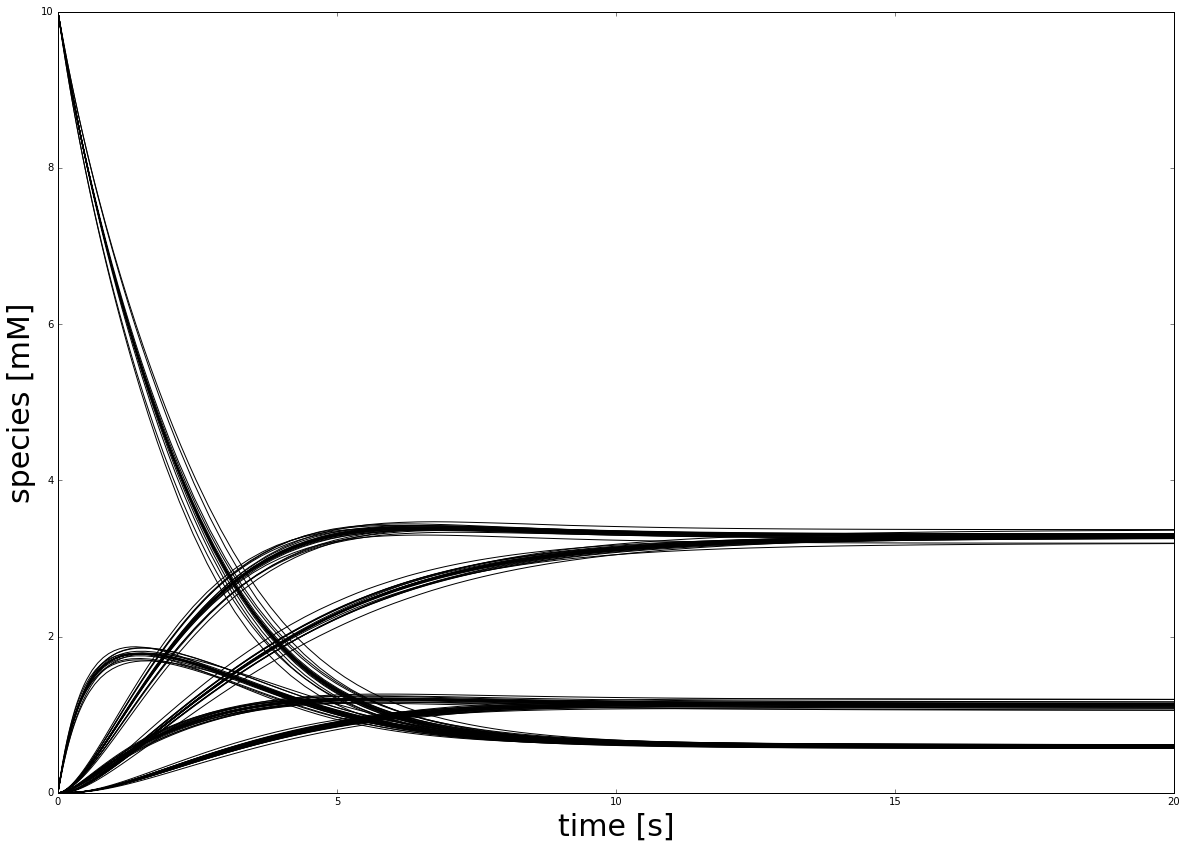

In [19]:
# Load the HDF5 files and plot them
from multiscale.odesim.simulate import solve_io
reload(solve_io)
plt.figure(figsize=(20,14))
for sim in simulations:
    result = Result.objects.get(simulation=sim, result_type=db_api.ResultType.HDF5)
    data, header = solve_io.load_hdf5(result.filepath)
    plt.plot(data[:,0], data[:,1:], '-', color='black')
    
plt.xlabel('time [s]', fontsize=plt_fontsize)
plt.ylabel('species [mM]', fontsize=plt_fontsize);

## Double parameter variation

For comparison all double parameter changes in the model are performed.  
How much larger are the combined effects of parameter changes?

In [20]:
# now we can setup the double variations
from multiscale.odesim.dist.samples import Sample, SampleParameter
samples_double = []
for pid1 in parameter_ids:
    for pid2 in parameter_ids:
        if pid1 == pid2:
            continue
        for f1 in factors:
            for f2 in factors:
        
                # create an empty sample
                s = Sample()
                # Set first parameter
                sp1 = SampleParameter(pid1, f1 * rr[pid1], unit=units[pid1], \
                             parameter_type=db_api.ParameterType.GLOBAL_PARAMETER)
                # Set second parameter
                sp2 = SampleParameter(pid2, f2 * rr[pid2], unit=units[pid2], \
                             parameter_type=db_api.ParameterType.GLOBAL_PARAMETER)
                s.add_parameters([sp1, sp2])
                samples_double.append(s)
print('Number of parameters:', len(parameter_ids))                
print('Number of samples:', len(samples_double))

('Number of parameters:', 13)
('Number of samples:', 624)


In [21]:
task_double = db_api.create_task(comp_model, method=method, info="Double parameter variation {}.".format(factors))

In [22]:
# Removing objects from the database
# from simapp.models import Task
# task_temp = Task.objects.get(pk=64)
# task_temp.delete()
# task_double.info = "Double parameter variation {}.".format(factors)
# task_double.save()

In [23]:
print('TaskStatus:', task.status_str)
from django.core.exceptions import ValidationError
try:
    # add the simulations to the task
    simulations_double = db_tools.create_simulations_from_samples(task_double, samples_double)
    # finalize task, so no additional simulations can be added
    task_double.finalize_status()
except ValidationError:
    simulations_double = task_double.simulations.all()
simulations
print('TaskStatus:', task.status_str)

('TaskStatus:', 'FINALIZED')
('TaskStatus:', 'FINALIZED')


In [24]:
import time
start = time.time()
solve.run_simulations(simulations_double, task_double)
duration = time.time() - start
print('Total time:', duration)

Task directory created: /home/mkoenig/multiscale-galactose-results/tmp_sim/T196
Loading : /home/mkoenig/multiscale-galactose-results/django/model/Koenig_demo_v09.xml
SBML load time: 0.0128829479218
Time: [0.0132|0.0011]
Time: [0.0123|0.0014]
Time: [0.0115|0.0012]
Time: [0.0112|0.0013]
Time: [0.0103|0.0010]
Time: [0.0111|0.0012]
Time: [0.0103|0.0010]
Time: [0.0107|0.0012]
Time: [0.0116|0.0014]
Time: [0.0120|0.0013]
Time: [0.0124|0.0015]
Time: [0.0118|0.0013]
Time: [0.0118|0.0012]
Time: [0.0117|0.0013]
Time: [0.0120|0.0015]
Time: [0.0125|0.0015]
Time: [0.0119|0.0013]
Time: [0.0118|0.0013]
Time: [0.0119|0.0013]
Time: [0.0118|0.0013]
Time: [0.0122|0.0014]
Time: [0.0123|0.0014]
Time: [0.0120|0.0014]
Time: [0.0114|0.0013]
Time: [0.0122|0.0012]
Time: [0.0135|0.0013]
Time: [0.0126|0.0013]
Time: [0.0129|0.0015]
Time: [0.0119|0.0011]
Time: [0.0132|0.0014]
Time: [0.0131|0.0013]
Time: [0.0131|0.0015]
Time: [0.0128|0.0012]
Time: [0.0130|0.0013]
Time: [0.0133|0.0016]
Time: [0.0127|0.0015]
Time: [0.0

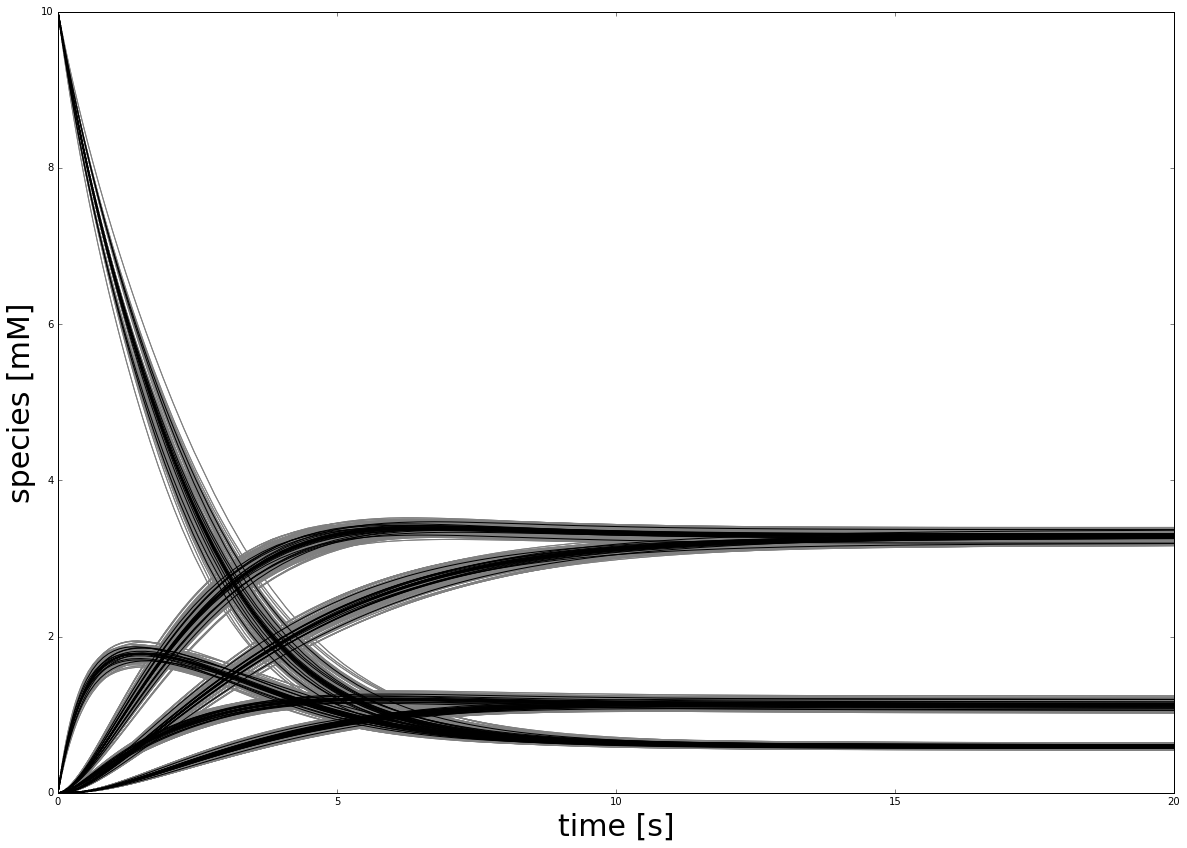

In [28]:
# Load the HDF5 files and plot them
from multiscale.odesim.simulate import solve_io
reload(solve_io)
plt.figure(figsize=(20,14))
for sim in simulations_double:
    result = Result.objects.get(simulation=sim, result_type=db_api.ResultType.HDF5)
    data, header = solve_io.load_hdf5(result.filepath)
    plt.plot(data[:,0], data[:,1:], '-', color='grey')
    
for sim in simulations:
    result = Result.objects.get(simulation=sim, result_type=db_api.ResultType.HDF5)
    data, header = solve_io.load_hdf5(result.filepath)
    plt.plot(data[:,0], data[:,1:], '-', color='black')
    
plt.xlabel('time [s]', fontsize=plt_fontsize)
plt.ylabel('species [mM]', fontsize=plt_fontsize)